In [40]:
import spacy
import json
import os
import numpy as np
import networkx as nx
import pandas as pd
from pprint import pprint
from spacy import displacy
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
def load_json_files(path_to_json):
    ####################
    #print(path_to_json)
    ####################
    json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
    #######################
    #print(json_files[3:4])
    #######################
    json_objects = list()
    for index, js in enumerate(json_files):
        #######################
        #print(index, ": ", js)
        #######################
        with open(os.path.join(path_to_json, js)) as json_file:
            json_objects.append(json.load(json_file))
    #####################
    #pprint(json_objects)
    #####################
    
    del json_objects[3]
    del json_objects[28-1]
    del json_objects[75-2]
    del json_objects[114-3]
    del json_objects[175-4]
    del json_objects[238-5]
    del json_objects[261-6]
    del json_objects[279-7]
    del json_objects[327-8]
    del json_objects[364-9]
    del json_objects[374-10]
    del json_objects[402-11]
    del json_objects[406-12]
    
    return json_objects#[:3]
##### index number 3, 28, 75, 114, 175, 238, 261, 279, 327, 364, 374, 402, 406 has denotation_span = None

In [42]:
nlp = spacy.load("en")

In [43]:
#span vs global id dictionary
span_g_id = dict()

In [44]:
def generate_token_info(json_objects):
    
    token_denotation_infos = dict()
    token_relation_infos = dict()
    
    #count for gene disease and expression
    gene_count = 1
    disease_count = 1
    expression_count = 1
    #regulation_count = 1
    
    #iterate through the json objects
    for jindex,json_object in enumerate(json_objects): 
        json_object_text = json_object["text"]
        json_object_denotations = json_object["denotations"]
        json_object_relations = json_object["relations"]
        json_object_pubmed_id = json_object["sourceid"]
        
        ##
        #pprint(json_object_relations)
        #print()
        
        #parsing text using spacy
        parsed_text = nlp(json_object_text)
        
        #local and global id dictionary for each json object
        lg_id = dict()
        
        #iterate through denotation within json object
        for index,denotation in enumerate(json_object_denotations):
            denotation_start = denotation["span"]["begin"]
            denotation_end = denotation["span"]["end"]
            denotation_span = parsed_text.char_span(denotation_start, denotation_end)
            denotation_span_str = str(denotation_span)
            
            ##
#             print("[", jindex, "]", denotation, "-> ", denotation_span, " : ", denotation_span_str)
            
            if denotation_span_str in span_g_id:
            ##
#                 print("if: ",denotation_span)
                for token in denotation_span:                
                    if str(token) in token_denotation_infos[span_g_id[denotation_span_str]]["tag"]:
                        if str(token.tag_) in token_denotation_infos[span_g_id[denotation_span_str]]["tag"][str(token)]:
                            token_denotation_infos[span_g_id[denotation_span_str]]["tag"][str(token)][str(token.tag_)] += 1
                            ##
#                             print(token_denotation_infos[span_g_id[denotation_span_str]]["tag"][token])
                        else:
                            token_denotation_infos[span_g_id[denotation_span_str]]["tag"].update({str(token) : {str(token.tag_) : 1}})
                    else:
                        token_denotation_infos[span_g_id[denotation_span_str]]["tag"].update({str(token) : {str(token.tag_) : 1}})
                lg_id[denotation["id"]] = span_g_id[denotation_span_str]
                ##
#                 pprint(token_denotation_infos)
            else:
                if ("expression" in denotation["obj"].lower() or "regulation" in denotation["obj"].lower()):
                    e = "e_" + json_object_pubmed_id + "_" + str(expression_count)
                    token_denotation_infos[e] = {"span" : denotation_span, "obj" : denotation["obj"],"tag" : dict()}#, "relation" : json_object_relations}

                    #populating span_g_id
                    span_g_id[denotation_span_str] = e
                    
                    #getting tag of tokens in denotation_span(disease or gene or expression)
                    for token in denotation_span:
                        
#                         token_denotation_infos[span_g_id[denotation_span_str]]["tag"][str(token)][str(token.tag_)] = token_denotation_infos[span_g_id[denotation_span_str]]["tag"].get(str(token),str(token.tag_)).get(str(token.tag_,1)+1
                        
                        if str(token) in token_denotation_infos[span_g_id[denotation_span_str]]["tag"]:
                            if str(token.tag_) in token_denotation_infos[span_g_id[denotation_span_str]]["tag"][str(token)]:
                                token_denotation_infos[span_g_id[denotation_span_str]]["tag"][str(token)][str(token.tag_)] += 1
                                ##
#                                 print(token_denotation_infos[span_g_id[denotation_span_str]]["tag"][token])
                            else:
                                token_denotation_infos[span_g_id[denotation_span_str]]["tag"].update({str(token) : {str(token.tag_) : 1}})
                        else:
                            token_denotation_infos[span_g_id[denotation_span_str]]["tag"].update({str(token) : {str(token.tag_) : 1}})

                    #populating lg_id
                    lg_id[denotation["id"]] = e

                    expression_count += 1

                elif ("cancer" in denotation["obj"].lower()):
                    d = "d_" + str(disease_count)

                    token_denotation_infos[d] = {"span" : denotation_span, "obj" : denotation["obj"],"tag" : dict()}#, "relation" : json_object_relations}

                    #populating span_g_id
                    span_g_id[denotation_span_str] = d
                    
                    #getting tag of tokens in denotation_span(disease or gene or expression)
                    for token in denotation_span:
                        if str(token) in token_denotation_infos[span_g_id[denotation_span_str]]["tag"]:
                            if str(token.tag_) in token_denotation_infos[span_g_id[denotation_span_str]]["tag"][str(token)]:
                                token_denotation_infos[span_g_id[denotation_span_str]]["tag"][str(token)][str(token.tag_)] += 1
                                ##
#                                  print(token_denotation_infos[span_g_id[denotation_span_str]]["tag"][token])
                            else:
                                token_denotation_infos[span_g_id[denotation_span_str]]["tag"].update({str(token) : {str(token.tag_) : 1}})
                        else:
                            token_denotation_infos[span_g_id[denotation_span_str]]["tag"].update({str(token) : {str(token.tag_) : 1}})

                    #populating lg_id
                    lg_id[denotation["id"]] = d

                    disease_count += 1

                elif ("gene" in denotation["obj"].lower()):
                    g = "g_" + str(gene_count)

                    token_denotation_infos[g] = {"span" : denotation_span, "obj" : denotation["obj"],"tag" : dict()}#, "relation" : json_object_relations}

                    #populating span_g_id
                    span_g_id[denotation_span_str] = g
                    
                    #getting tag of tokens in denotation_span(disease or gene or expression)
                    for token in denotation_span:
                        if str(token) in token_denotation_infos[span_g_id[denotation_span_str]]["tag"]:
                            if str(token.tag_) in token_denotation_infos[span_g_id[denotation_span_str]]["tag"][str(token)]:
                                token_denotation_infos[span_g_id[denotation_span_str]]["tag"][str(token)][str(token.tag_)] += 1
                                ##
#                                 print(token_denotation_infos[span_g_id[denotation_span_str]]["tag"][token])
                            else:
                                token_denotation_infos[span_g_id[denotation_span_str]]["tag"].update({str(token) : {str(token.tag_) : 1}})
                        else:
                            token_denotation_infos[span_g_id[denotation_span_str]]["tag"].update({str(token) : {str(token.tag_) : 1}})

                    #populating lg_id
                    lg_id[denotation["id"]] = g

                    gene_count += 1
                    
                else:
                    print("EXCEPTION: ", denotation, "-> ", denotation_span)
                    span_g_id[denotation_span_str] = "EXCEPTION"
                    lg_id[denotation["id"]] = "EXCEPTION"
        ##
        #print(lg_id)
        #print()

        relations = list()
        for index,relation in enumerate(json_object_relations):
            relations.append({"subj" : lg_id[relation["subj"]], "obj" : lg_id[relation["obj"]], "pred" : relation["pred"]})
        token_relation_infos[json_object_pubmed_id] = relations
##
#     print(span_g_id)
    #pprint(token_denotation_infos)
    #print()
    #pprint(token_relation_infos)
    
    return token_denotation_infos, token_relation_infos

In [73]:
all__ = list()
#sentences by article.
sen_art = dict()

In [86]:
def get_sentences_containing_denotations(json_objects):
    
    exression_list = [ k for k,v in span_g_id.items() if v.startswith("e_")]
#     print(exression_list)
    other_list = [ k for k,v in span_g_id.items() if not v.startswith('e_')]
#     print(other_list)
    all__ = exression_list + other_list
    print(all__)
    #iterate through the json objects
    for json_object in json_objects: 
        json_object_text = json_object["text"]
        json_object_pubmed_id = json_object["sourceid"]
                
        #parsing text using spacy
        parsed_text = nlp(json_object_text)
        
        for ex in all__:
#             print(ex)
            sen_art[json_object_pubmed_id] = {sent.string.strip().replace(ex, span_g_id[ex]) for sent in parsed_text.sents if ex in sent.string.strip()}
#             print(ex, " -> ", span_g_id[ex])
#         break
#     return sen_art

In [47]:
path_to_json = "F:/UB/2nd Sem/Basic Projects/Graph Data mining for Gene Cancer relation/CoMAGC-annotations/CoMAGC/"
json_objects = load_json_files(path_to_json)
nodes_info, edges_info = generate_token_info(json_objects)

In [87]:
get_sentences_containing_denotations(json_objects)

['induction', 'expression', 'positive', 'stimulate', 'overexpression', 'Overexpression', 'activate', 'overexpressed', 'upregulated', 'up-regulation', 'repression', 'Elevated', 'loss', 'Up-regulation', 'disruption', 'inhibition', 'increased', 'Transfection', 'stimulation', 'induced', 'suppress', 'elevated', 'increase', 'accumulated', 'depressed', 'Inhibition', 'attenuates', 'co-transfection', 'Increase', 'higher', 'depletion', 'decrease', 'block', 'levels', 'Increased', 'suppression', 'reduction', 'overexpress', 'down-regulation', 'Induction', 'down-regulated', 'activation', 'up-regulated', 'inhibits', 'enhanced', 'decreased', 'absence', 'inducing', 'Decreased', 'deleted', 'accumulation', 'augmented', 'activated', 'stimulates', 'reduced', 'abrogation', 'reduces', 'induces', 'overexpressing', 'transfected', 'decreases', 're-activation', 'downregulation', 'upregulation', 'blockade', 'inhibited', 'Overexpressing', 'blocking', 'Down-regulation', 'increasing', 'reduce', 'Knockdown', 'Transfe

In [85]:
# print(span_g_id)
print(all__)
print(sen_art)

[]
{'10067845': set()}


In [50]:
def get_nodes_labels(node_infos):
    nodes = list()
    n_labels = dict()
    for node,info in node_infos.items():
        nodes.append(node)
        n_labels[node] = str(info["span"])
    return nodes, n_labels

def get_edge_labels(edge_infos):
    e_labels = dict()
    for k,edges in edge_infos.items():
        for edge in edges:
            e_labels[(edge["subj"],edge["obj"])] = e_labels.get((edge["subj"],edge["obj"]), edge["pred"]) + "/" + edge["pred"]
    return e_labels

def get_edges_labels_weights():
    labels = get_edge_labels(edges_info)
    e_labels = dict()
    edges = list()
    for key, value in labels.items():
        v_arr = value.split("/")
        v_dict = dict()
        weight = 0
        l = ""
        for x in v_arr:
            v_dict[x] = v_dict.get(x,0) + 1
        k_list = list(v_dict.keys())
        for k, v in v_dict.items():
            if k == k_list[-1]:
                l += str(k) + "*" + str(v)
            else:
                l += str(k) + "*" + str(v) + ", "
            weight += v
        nkey = key + (weight,)
        e_labels[key] = l
        edges.append(nkey)
#         for et, el in e_labels.items():
#             edges.append(et)
            #e_labels[et] = el
    return edges, e_labels

In [51]:
def compute_node_size(min_degree, max_degree, nds):
    node_sizes = list()
    for nd in nds:
        node_sizes.append(list(nd))
                          
    for index,nd in enumerate(node_sizes):
        if nd[1] == 0:
            node_sizes[index][1] = (((max_degree-min_degree)/500)+200)*0.5
        else:
            node_sizes[index][1] = (((max_degree-min_degree)/500)+200)*nd[1]
                          
    return node_sizes

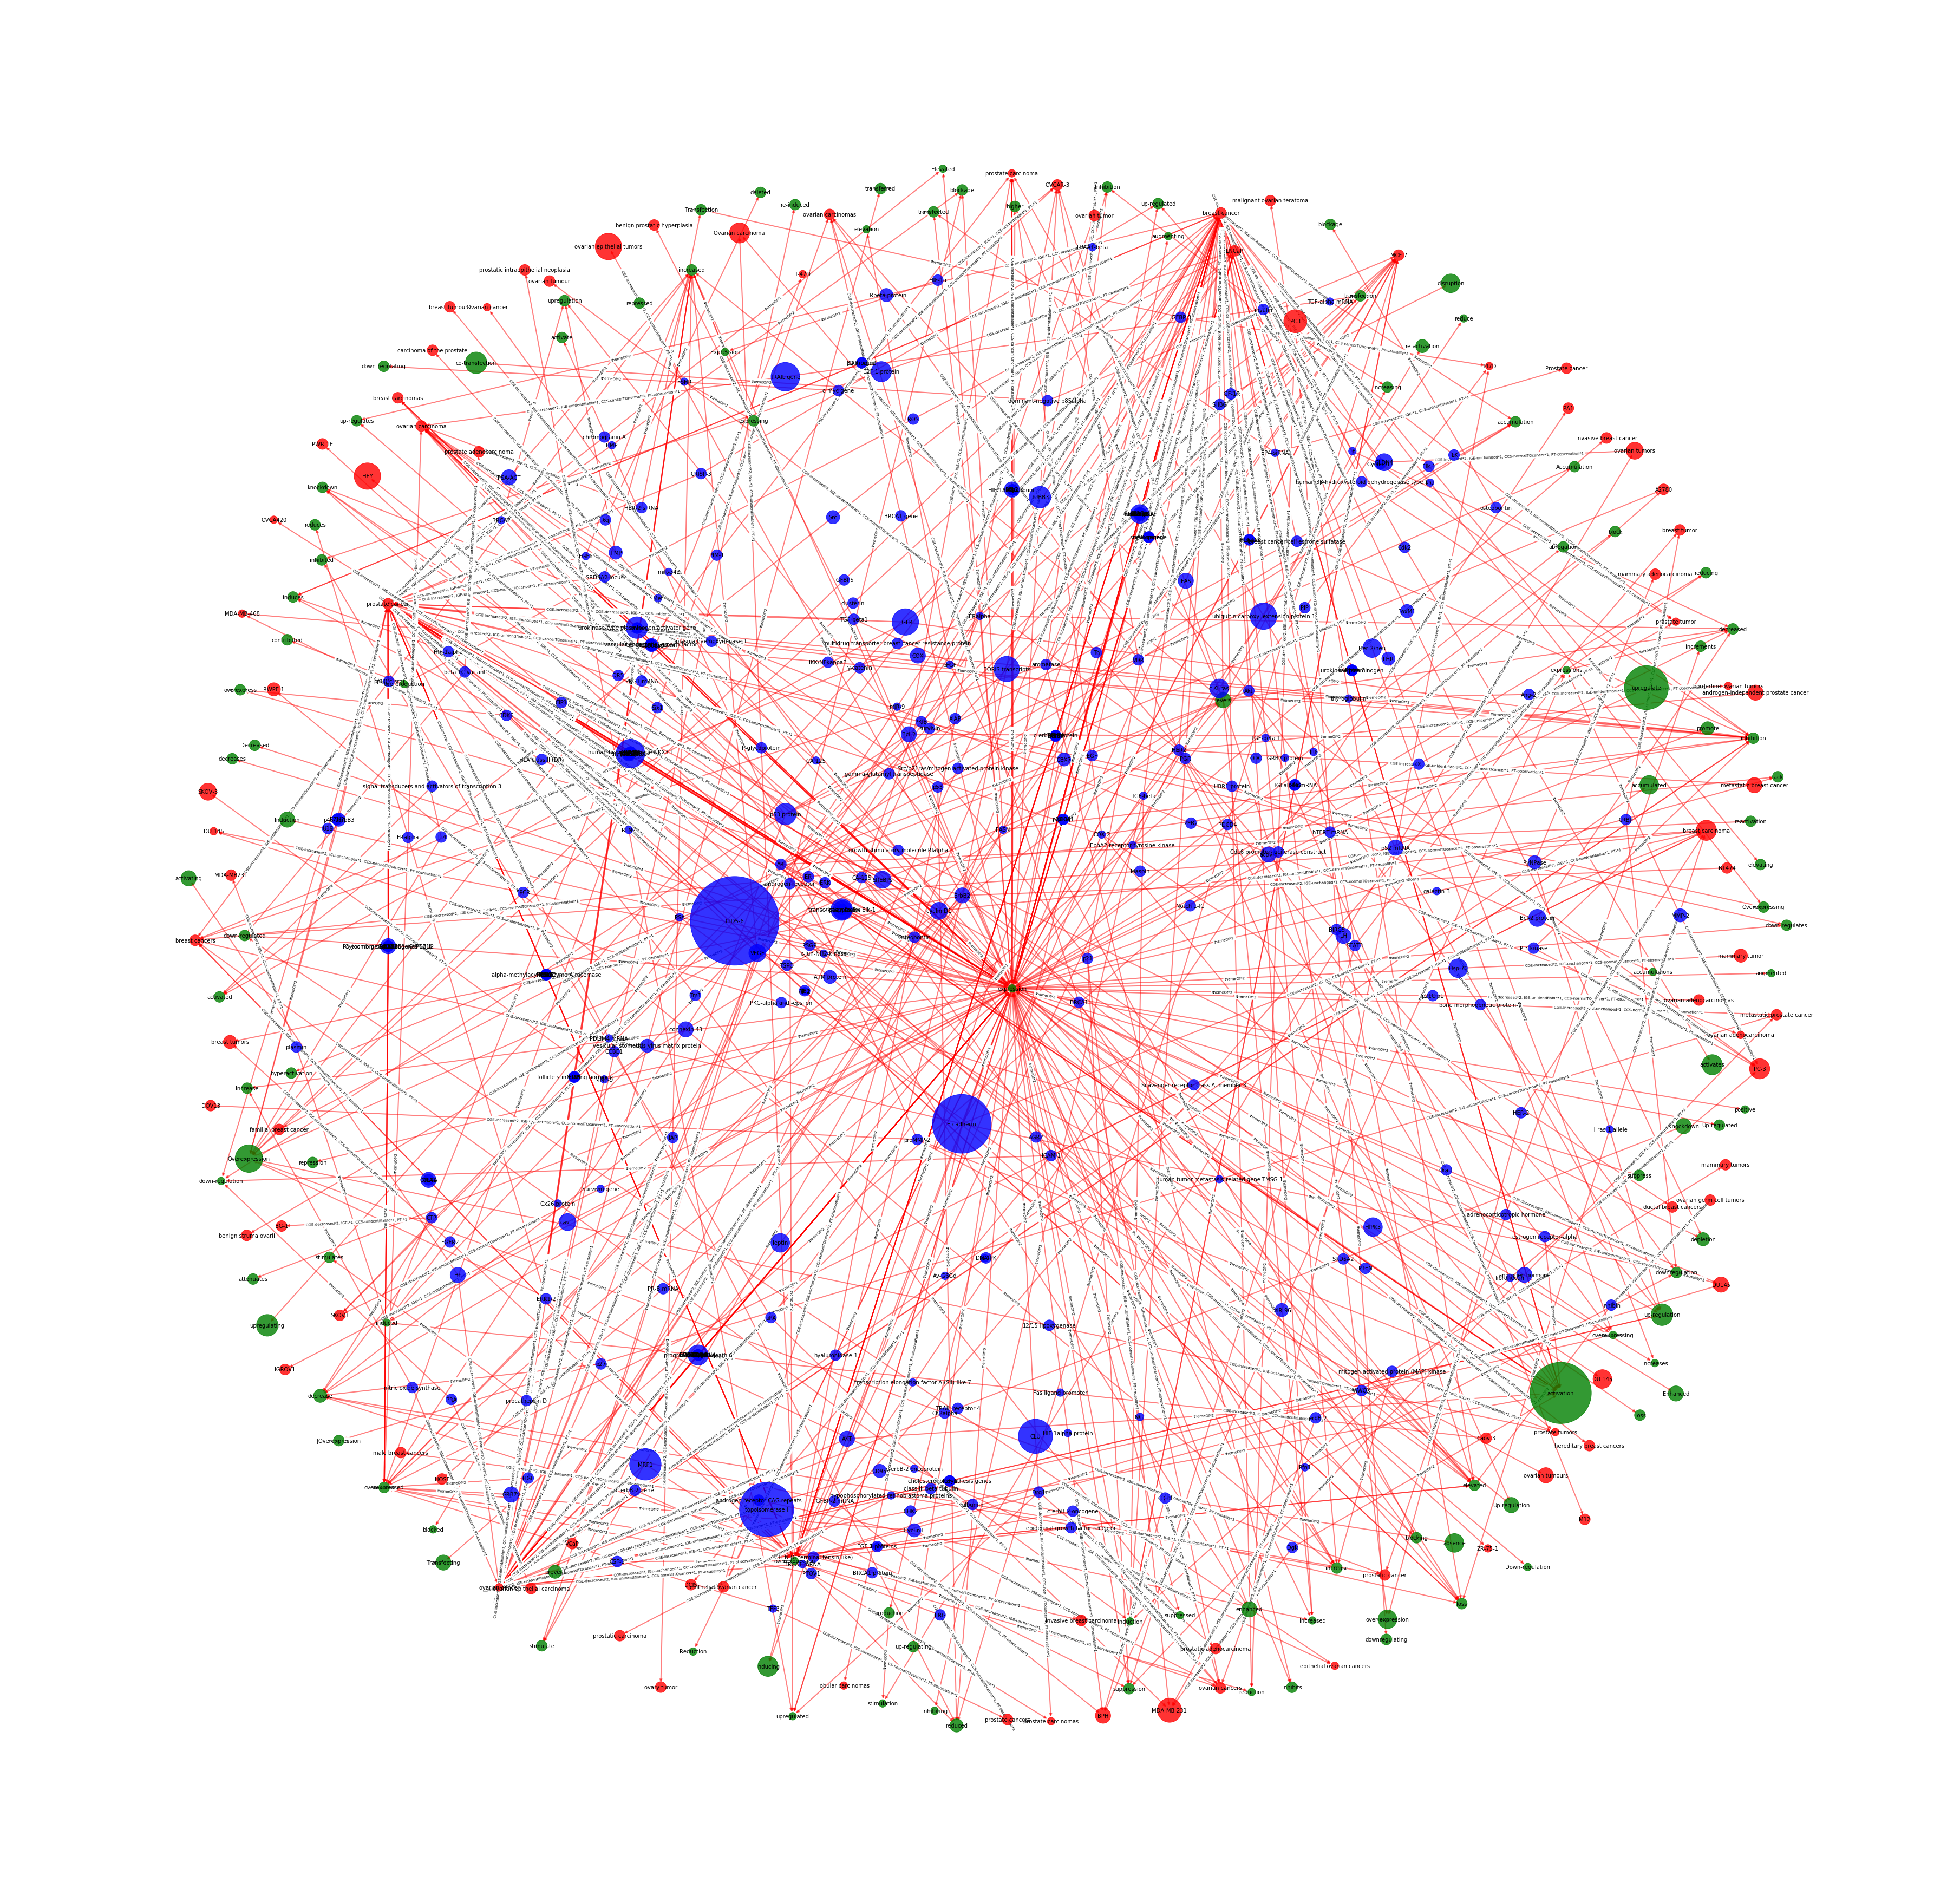

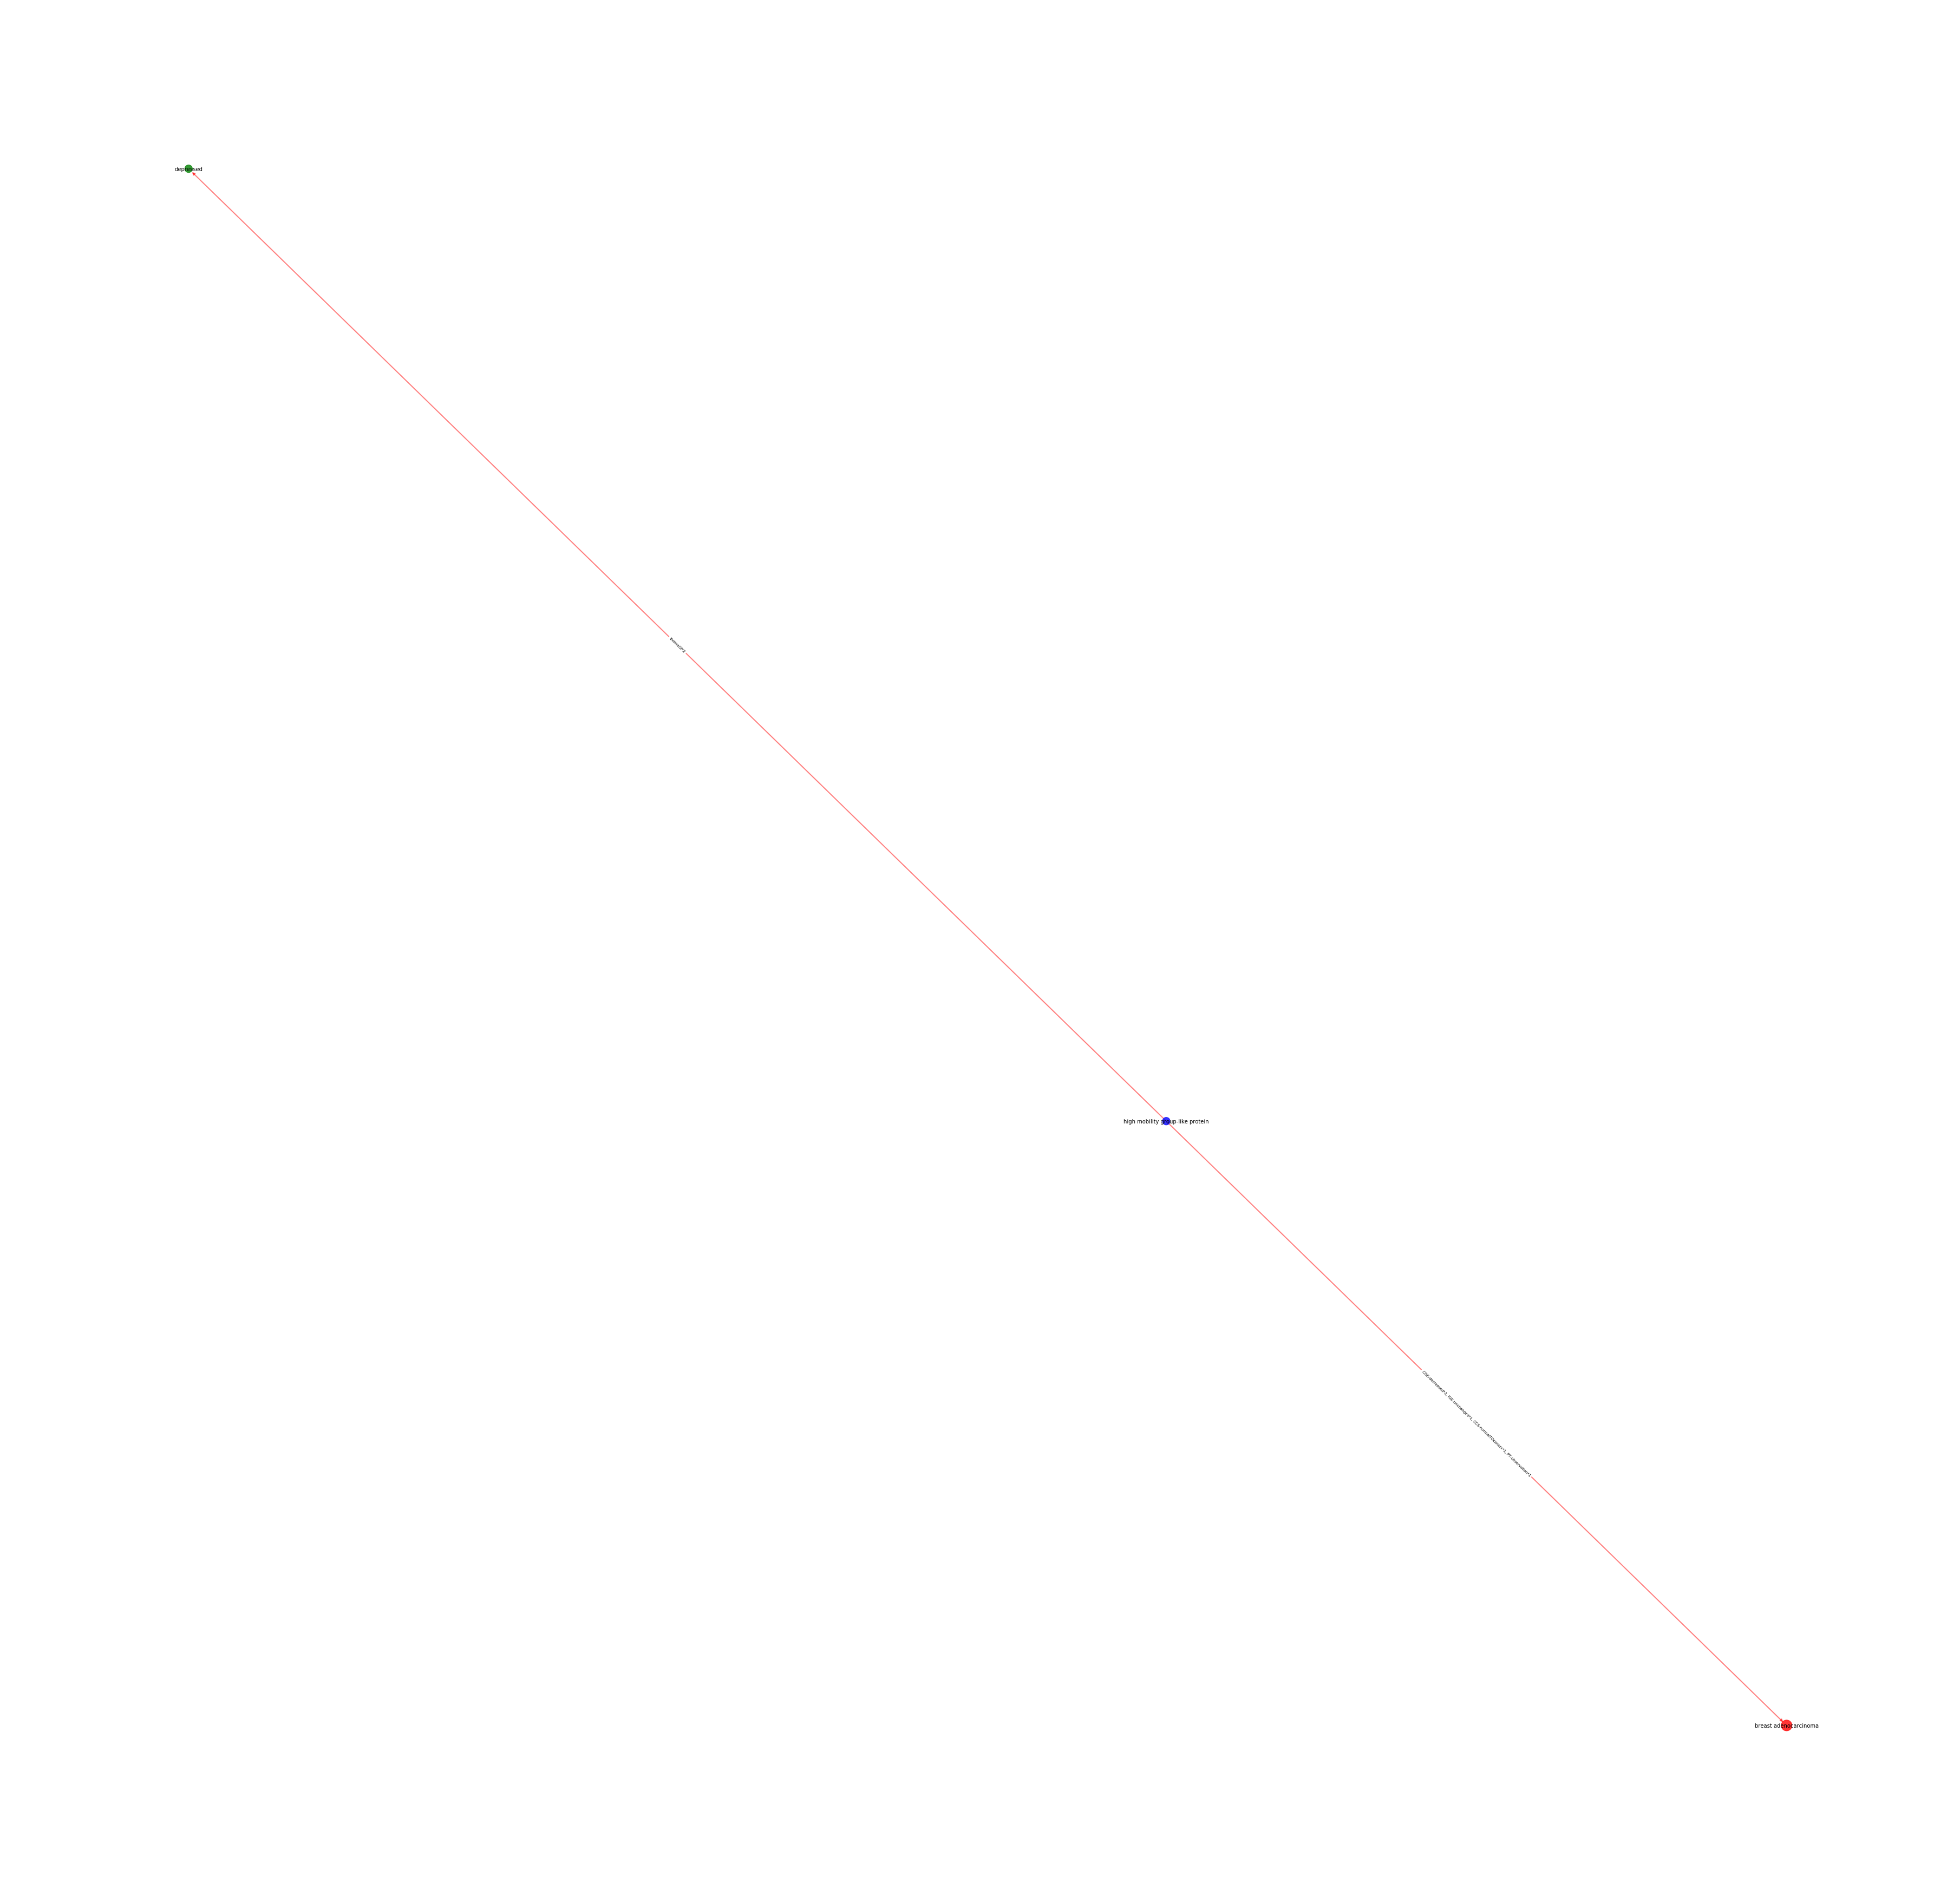

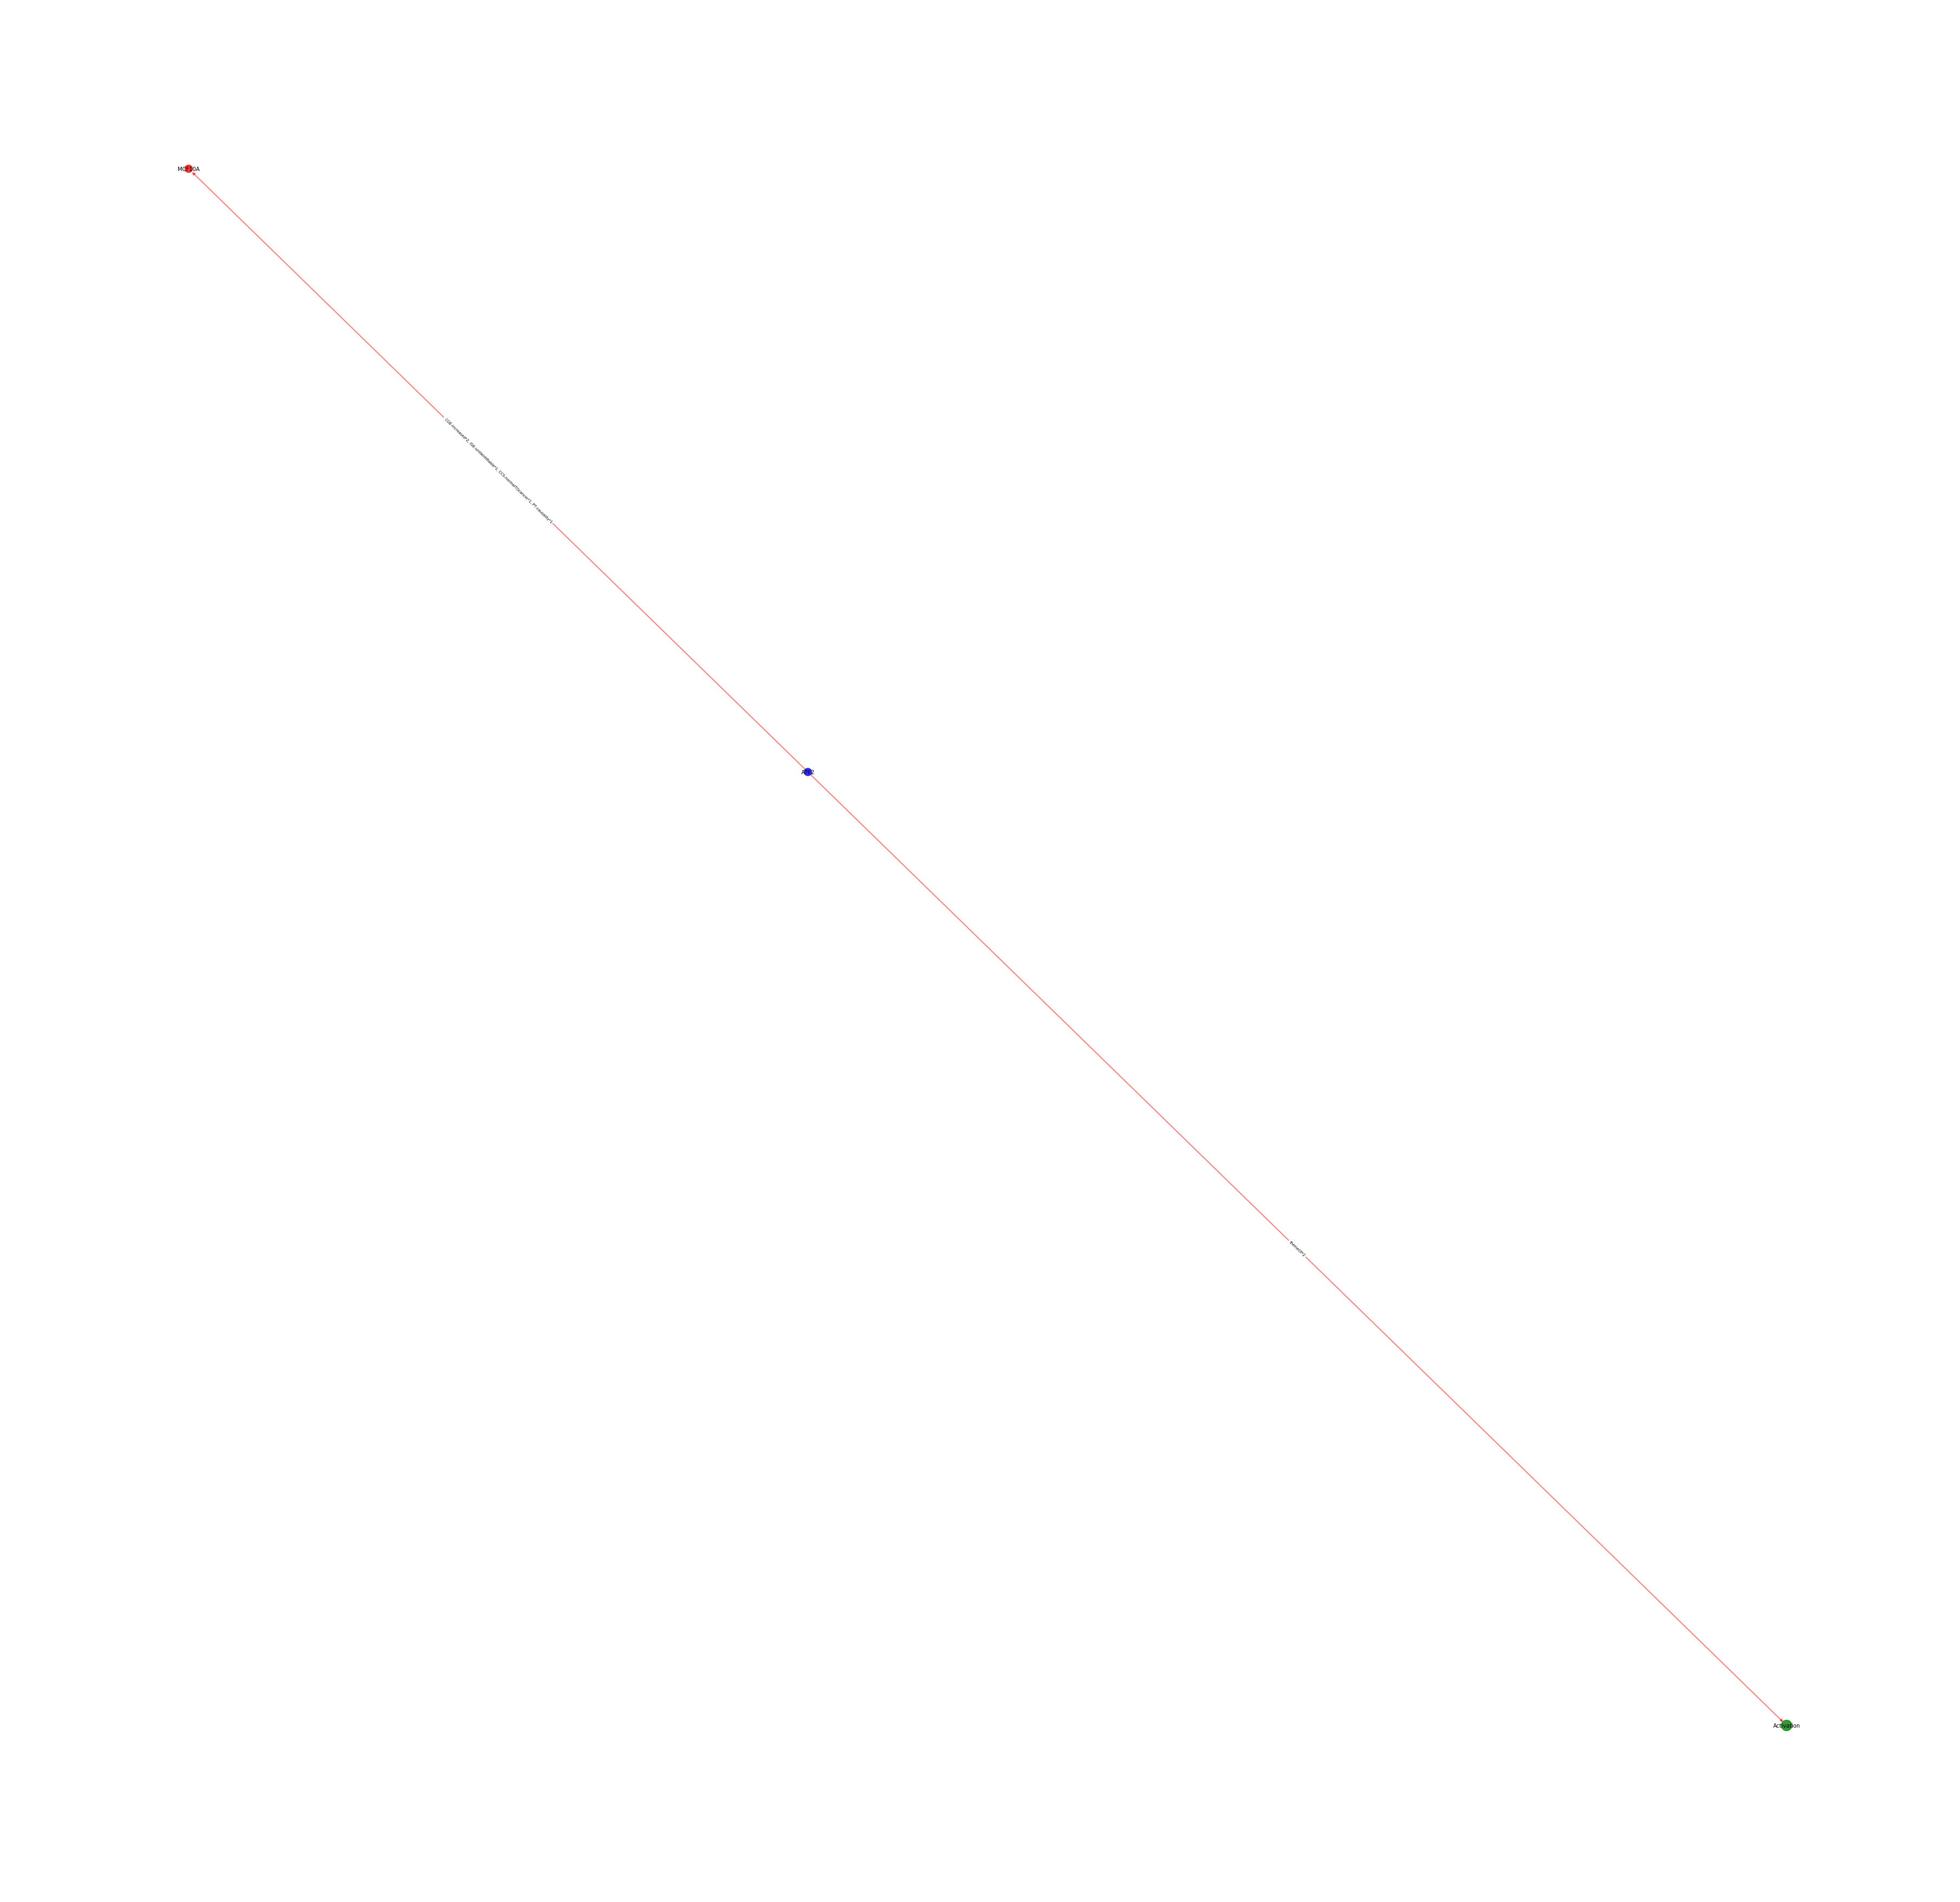

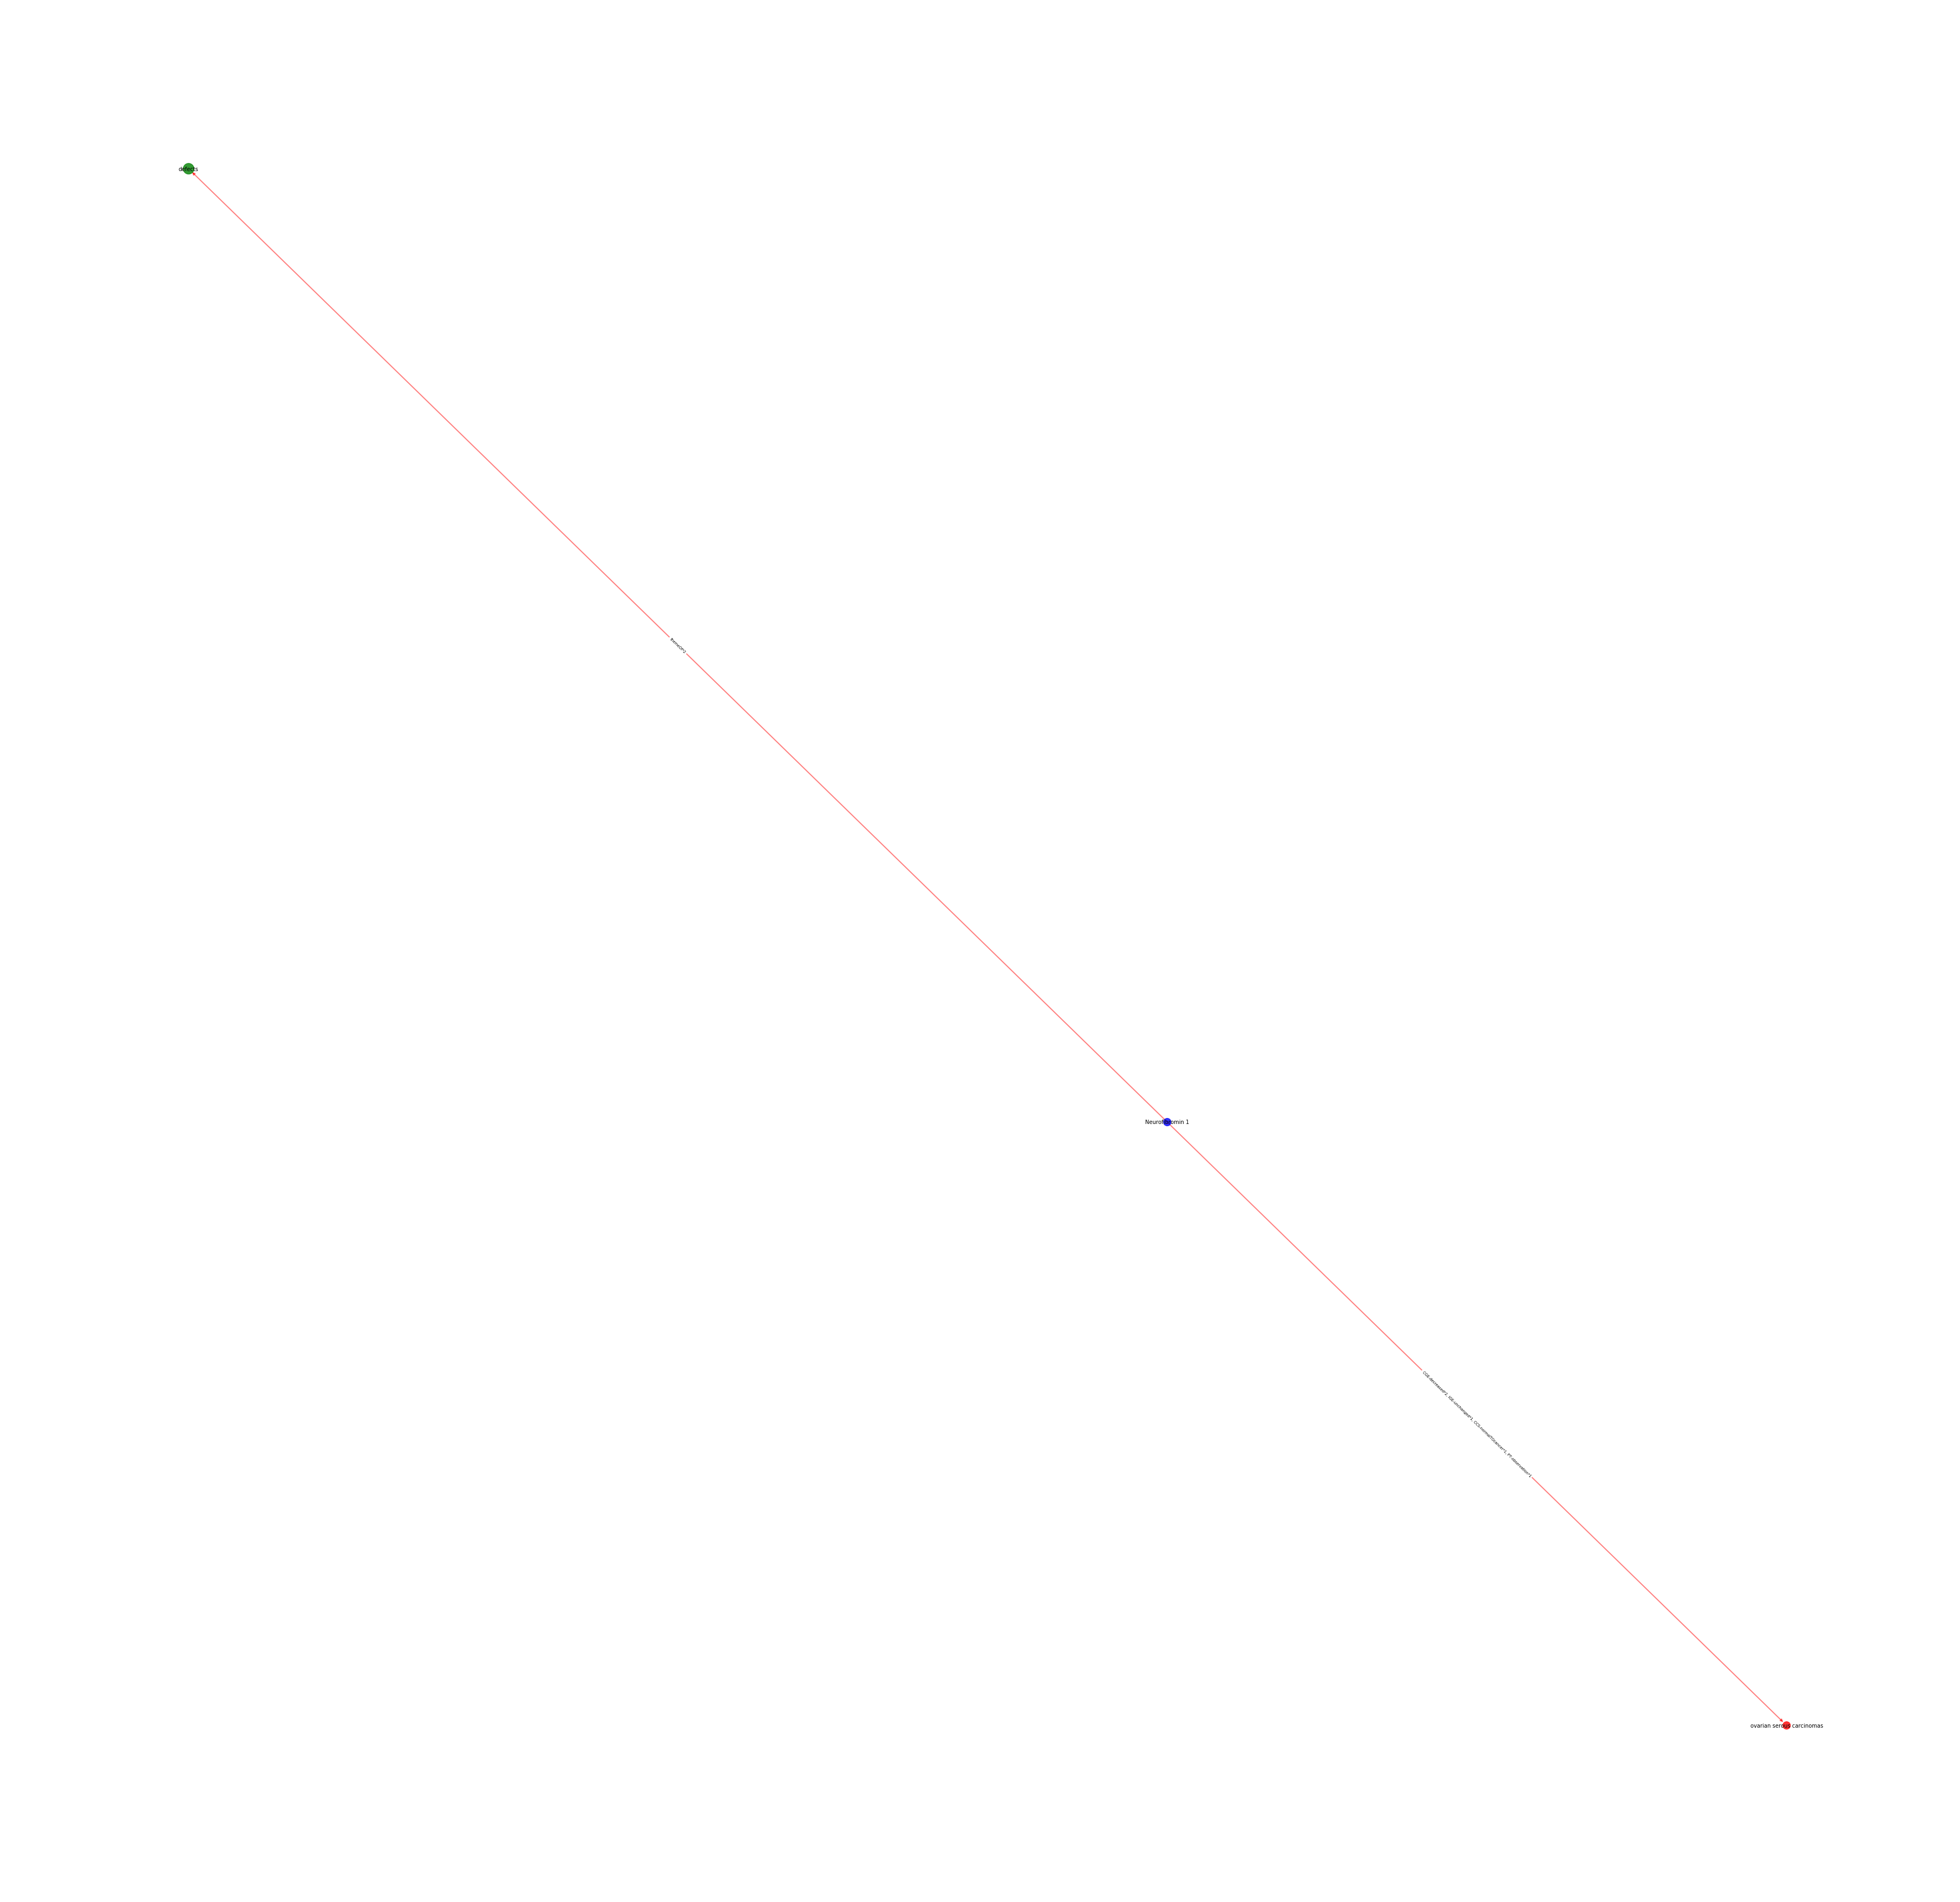

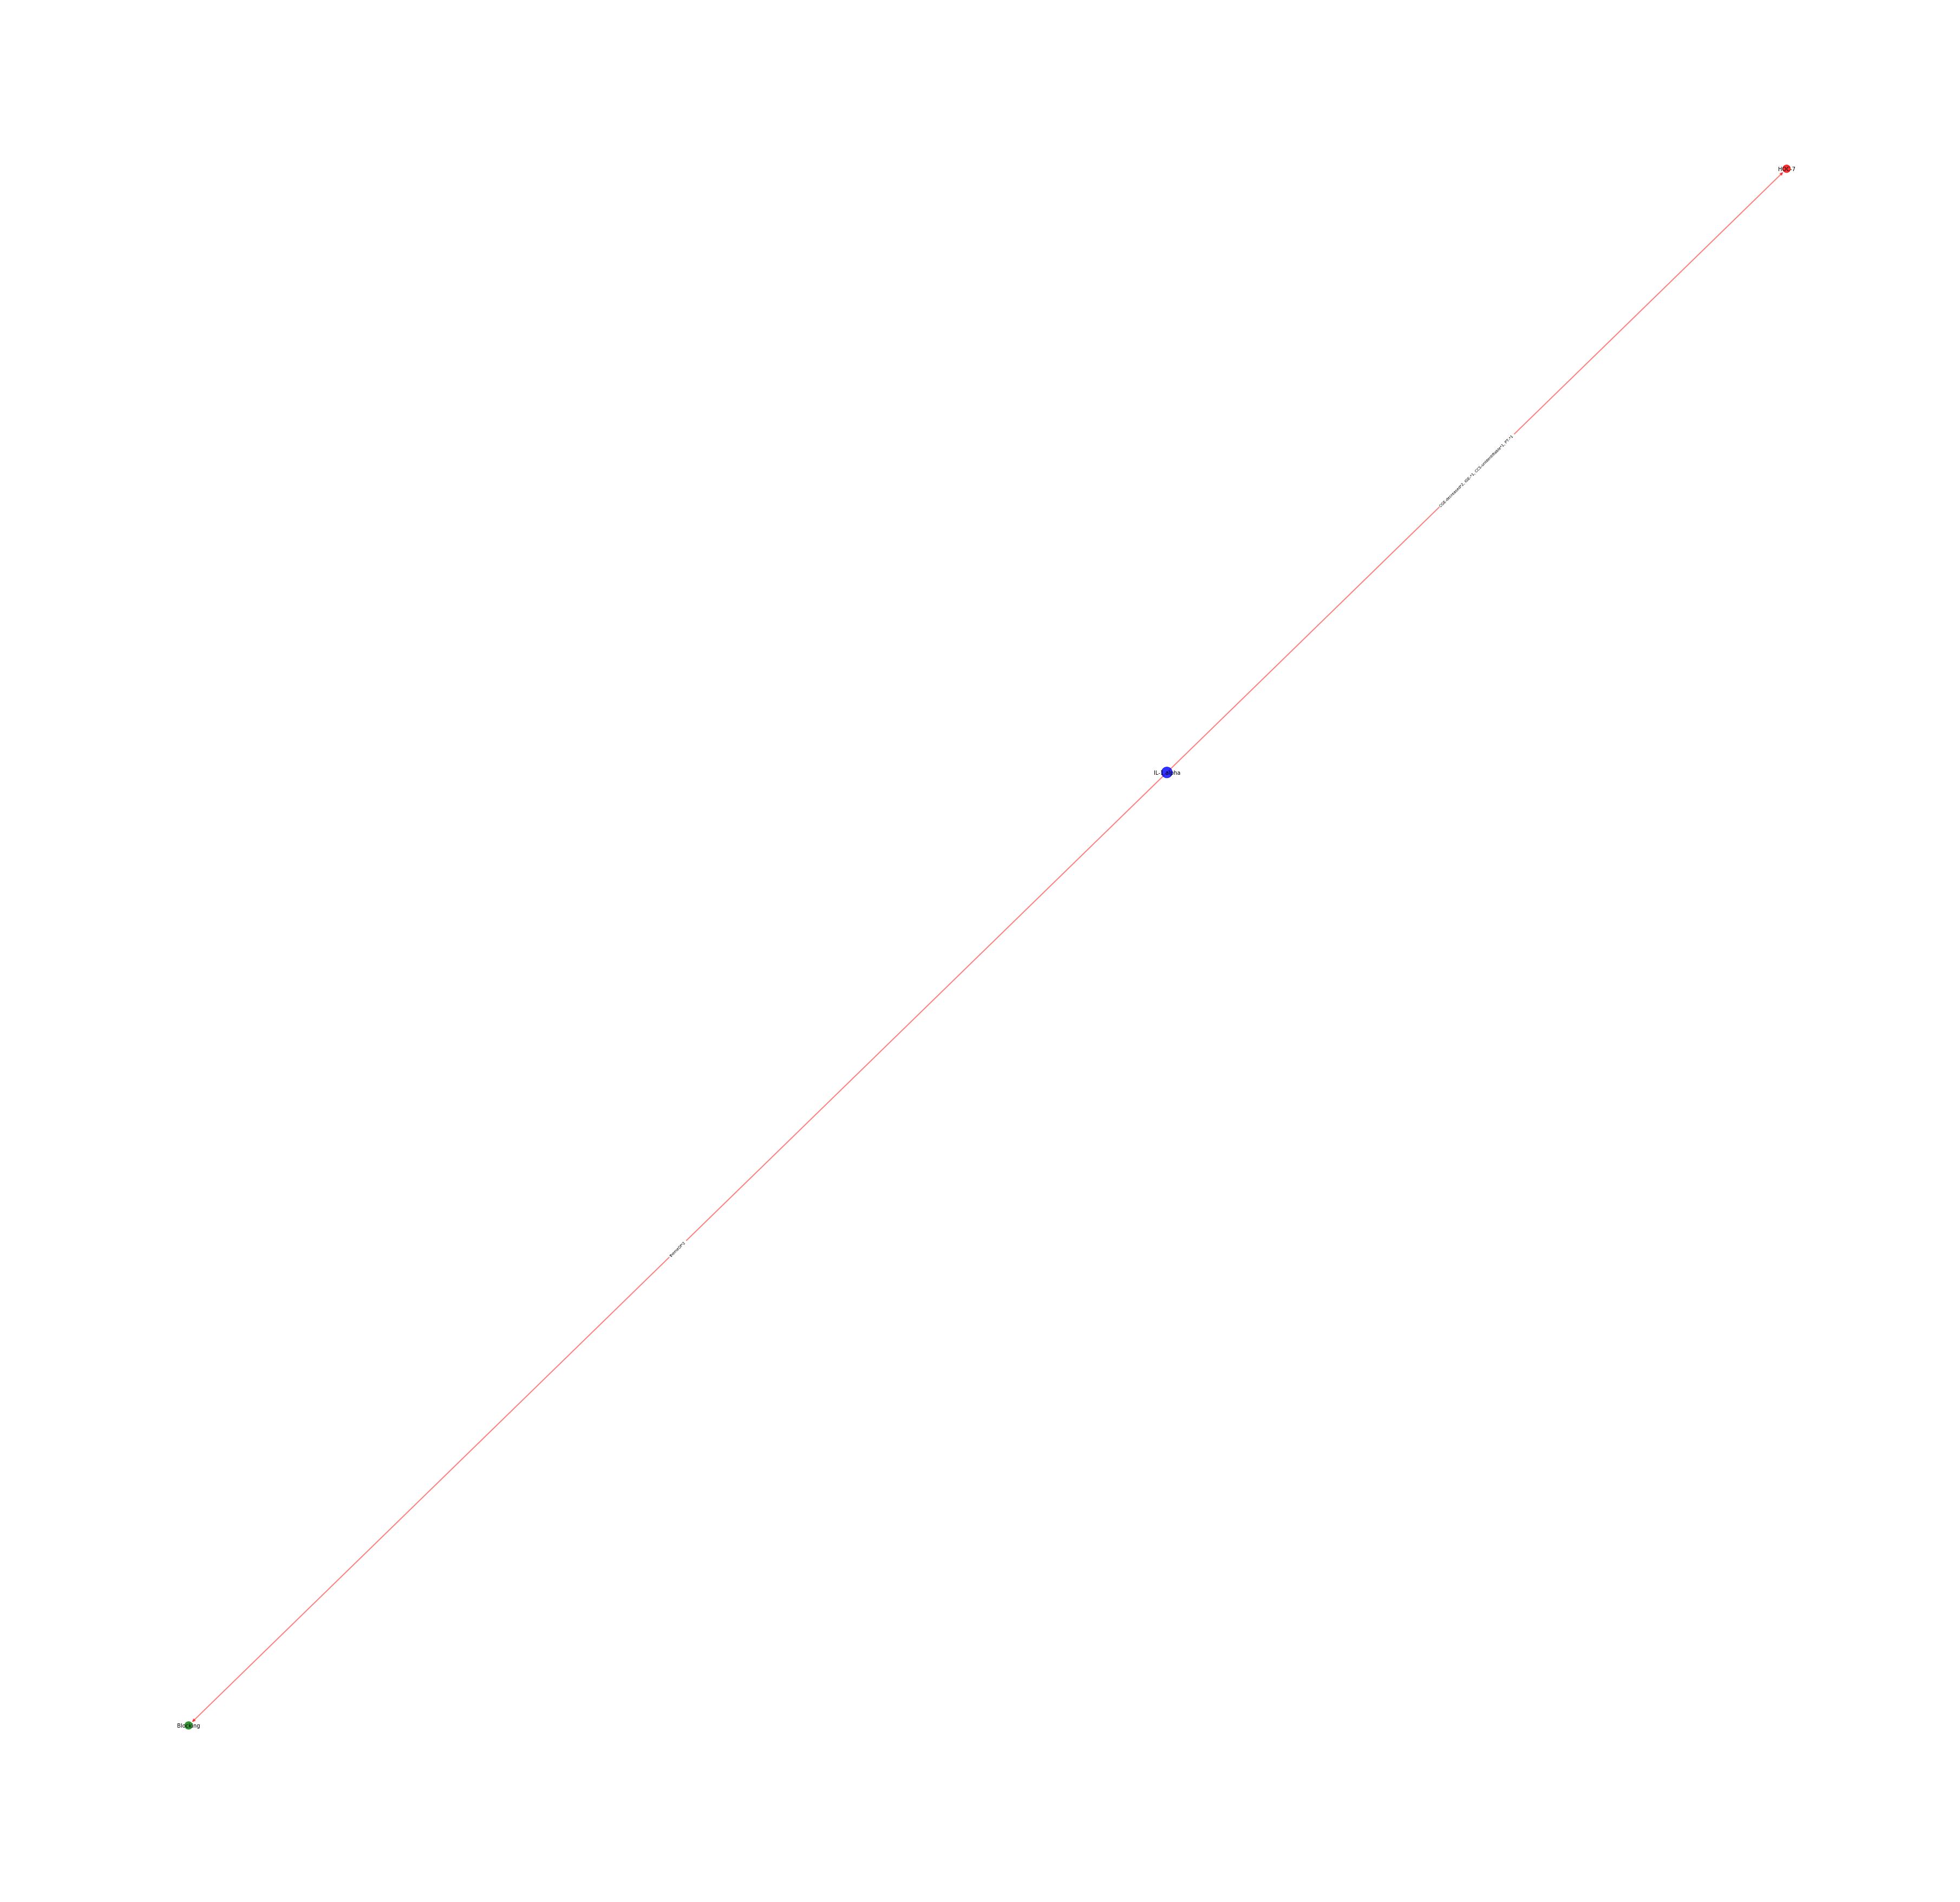

In [52]:
###try outs

# print()
nodes, n_labels = get_nodes_labels(nodes_info)
edges, e_labels = get_edges_labels_weights()

# a = [n for n in nodes if "e_" in n]
# print(a)


def initialize_graph(nodes, edges):
    g = nx.DiGraph()


    g.add_nodes_from(nodes)
    g.add_weighted_edges_from(edges)
    
    return g

def draw_graph (nodes, n_labels, edges, e_labels):
    g = initialize_graph(nodes, edges)
    n_out_degree = g.degree(nodes)
#     n_out_degree = dict(n_out_degree)

    min_pair = min(n_out_degree, key = lambda t: t[1])
    max_pair = max(n_out_degree, key = lambda t: t[1])
###
#     print(min_pair)
#     print(max_pair)

    node_sizes = compute_node_size(min_pair[1], max_pair[1], n_out_degree)
    

    for component in sorted(nx.weakly_connected_component_subgraphs(g), key = len, reverse = True):
    #     print(component.nodes())
        if len(component) < 2:
            continue
        #matplotlib graph size
        plt.figure(1, figsize = (64,64))

        #networkx layout
        pos = nx.spring_layout(component)
        #pos = nx.circular_layout(component)

        #subgraph nodes and labels
        cmp_n_labels = dict((key, value) for key, value in n_labels.items() if key in component.nodes())
        cmp_n_colors = list()
        for key in component.nodes():
            if "g_" in key:
                value = "b"
            elif "d_" in key:
                value = "r"
            else:
                value = "g"
            cmp_n_colors.append(value)
        
        nx.draw_networkx_nodes(component, pos, nodelist = component.nodes(), node_color=cmp_n_colors, 
                               node_size = [v[1] for v in node_sizes if v[0] in component.nodes()], alpha=0.8)
        nx.draw_networkx_labels(component, pos, cmp_n_labels, font_size=10)

        #subgraph edges and labels
        cmp_e_labels = dict((key, value) for key, value in e_labels.items() if key in component.edges())

        nx.draw_networkx_edges(component, pos, edgelist=component.edges(), width=2, alpha=0.5, edge_color='r')
        nx.draw_networkx_edge_labels(component, pos, edge_labels = cmp_e_labels, font_size=7)

        plt.axis('off')
        plt.savefig("test.pdf")
#         break
        plt.show()
        
draw_graph(nodes, n_labels, edges, e_labels)

### ---------------------------------------------------------

In [53]:
#### orignaly written
# print()
nodes, n_labels = get_nodes_labels(nodes_info)
edges, e_labels = get_edges_labels(edges_info)

g = nx.DiGraph()

#nodes and labels
g.add_nodes_from(nodes)
g.add_edges_from(edges)

plt.figure(1, figsize = (14,14))
pos = nx.spring_layout(g)
#pos = nx.circular_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color='r', node_size=500, alpha=0.8)
nx.draw_networkx_labels(g, pos, n_labels, font_size=10)

#edges and labels

nx.draw_networkx_edges(g, pos, edgelist=edges, width=2, alpha=0.5, edge_color='r')
nx.draw_networkx_edge_labels(g, pos, edge_labels = e_labels, font_size=7)

plt.axis('off')
plt.show()

NameError: name 'get_edges_labels' is not defined